## Demo of bmtool synaptic tuner
### First we must define some general settings and the settings for the connection we would like to tune. Below is an example of what this could look like for excitatory and inhibitory connections. Currently all of these settings, but the ones in the spec_syn_param are needed in order to use the tuner. You can copy all of the general_settings as these should be general enough to use for any case. The spec_settings are going to depend on your exact use case and connection type 

In [1]:
general_settings = {
    'vclamp': True, # if vclamp should start on or off used mostly for singleEventv
    'rise_interval': (0.1, 0.9), #10-90%
    'tstart': 500., # when the singleEvent should start
    'tdur': 100.,    # Dur of sim after single synaptic event has occured
    'threshold': -15., #threshold for spike in mV
    'delay': 1.3, # netcon delay
    'weight': 1., # netcon weight
    'dt': 0.025, # simulation dt
    'celsius': 20 # temp of sim
}

conn_type_settings = {
    'Fac2FSI': { # facilitating synapse 
        'spec_settings': {
            'post_cell': 'FSI_Cell', 
            'vclamp_amp' : -70., 
            'sec_x': 0.5, 
            'sec_id': 1,  
            "level_of_detail": "AMPA_NMDA_STP",
        },
        'spec_syn_param': {
            'initW': 0.76,
            'tau_r_AMPA': 0.45,
            'tau_d_AMPA': 7.5,
            'Use': 0.13,
            'Dep': 0.,
            'Fac': 200.
        },
    },
    'Dep2FSI': { # depressing synapse
        'spec_settings': {
            'post_cell': 'FSI_Cell',
            'vclamp_amp': -55,
            'sec_x': 0.5,
            'sec_id':0,
            "level_of_detail": "GABA_A_STP",
        },
        'spec_syn_param': {
            'initW': 20,
            'tau_r_GABAA': 0.9,
            'tau_d_GABAA': 15,
            'e_GABAA':-75,
            'Use': 0.4,
            'Dep': 190.,
            'Fac': 0.
        },
    },

}

### Then the modfiles must be compiled in order for the tuner to work properly 

In [2]:
import os

# if already compiled then lets delete the folder and force a recompile
if os.path.isdir('modfiles/x86_64'):
    os.system("rm -rf modfiles/x86_64 ")
# compile the mod files
if not os.path.isdir("modfiles/x86_64"):
    os.chdir('modfiles')
    os.system("nrnivmodl")
    os.chdir("..")

/home/gjgpb9/miniconda3/envs/bmtk/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


/home/gjgpb9/cortex_modeling/bmtool/examples/synapses/modfiles
Mod files: "./AMPA_NMDA_STP.mod" "./cadad.mod" "./cal2.mod" "./can_mig.mod" "./exp2syn_stp.mod" "./GABA_A_STP.mod" "./gap.mod" "./Gfluct.mod" "./h_kole.mod" "./imCA3.mod" "./kap_BS.mod" "./kBK.mod" "./kdmc_BS.mod" "./kdr_BS.mod" "./kdrCA3.mod" "./kdrinter.mod" "./leak.mod" "./nainter.mod" "./napCA3.mod" "./natCA3.mod" "./nax_BS.mod" "./vecevent_coreneuron.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../AMPA_NMDA_STP.mod
 -> NMODL ../cadad.mod
 -> NMODL ../cal2.mod
 -> NMODL ../can_mig.mod
 -> NMODL ../exp2syn_stp.mod
 -> NMODL ../GABA_A_STP.mod
 -> NMODL ../gap.mod
 -> NMODL ../Gfluct.mod
 -> NMODL ../h_kole.mod
 -> NMODL ../imCA3.mod
 -> NMODL ../kap_BS.mod
 -> NMODL ../kBK.mod
 -> NMODL ../kdmc_BS.mod
 -> NMODL ../kdr_BS.mod
 -> NMODL ../kdrCA3.mod
 -> NMODL ../kdrinter.mod
 -> NMODL ../leak.mod
 -> NMODL ../nainter.mod
 -> NMODL ../napCA3.mod
 -> NMODL ../natCA3.mod
 -> NMODL ../n

Translating AMPA_NMDA_STP.mod into /home/gjgpb9/cortex_modeling/bmtool/examples/synapses/modfiles/x86_64/AMPA_NMDA_STP.c
Translating cal2.mod into /home/gjgpb9/cortex_modeling/bmtool/examples/synapses/modfiles/x86_64/cal2.c
Translating cadad.mod into /home/gjgpb9/cortex_modeling/bmtool/examples/synapses/modfiles/x86_64/cadad.c
Thread Safe
Thread Safe
Thread Safe
Translating can_mig.mod into /home/gjgpb9/cortex_modeling/bmtool/examples/synapses/modfiles/x86_64/can_mig.c
Thread Safe
Translating exp2syn_stp.mod into /home/gjgpb9/cortex_modeling/bmtool/examples/synapses/modfiles/x86_64/exp2syn_stp.c
Translating GABA_A_STP.mod into /home/gjgpb9/cortex_modeling/bmtool/examples/synapses/modfiles/x86_64/GABA_A_STP.c
Translating gap.mod into /home/gjgpb9/cortex_modeling/bmtool/examples/synapses/modfiles/x86_64/gap.c
Thread Safe
Thread Safe
Thread Safe
Translating Gfluct.mod into /home/gjgpb9/cortex_modeling/bmtool/examples/synapses/modfiles/x86_64/Gfluct.c
Notice: This mechanism cannot be used 

 => LINKING executable ./special LDFLAGS are:    -pthread
Successfully created x86_64/special


### Now we can initialize the synaptic tuner. You must call the SingleEvent method before using the interactiveTuner. When initializing you will have to change a few arguments depending on your use case. other_vars_to_record can be any variable in your synaptic mechanism, while slider_vars can be any range variable you wish to tune in the synapse. If the variable is not defined in the spec_syn_param than the tuner will get the value from the mechanism and try to set up some sliders to tune it.

In [3]:
mechanisms_dir = 'modfiles'
templates_file = 'templates.hoc'
#json_folder_path = os.path.join('..', 'Model-Parameters' , 'components', 'synaptic_models','synapses_M1_match')
# Initialize the SynapseModule
from bmtool.synapses import SynapseTuner
synapse_module = SynapseTuner(mechanisms_dir=mechanisms_dir, # where x86_64 is located
                               templates_dir=templates_file, # where the neuron templates are located
                               conn_type_settings=conn_type_settings, # dict of connection settings
                               general_settings = general_settings, # dict of general settings
                               connection = 'Fac2FSI', # key in connection settings for which connection you want to tune
                               #json_folder_path=json_folder_path, # If your network uses json files the path can be set to update the connection settings based on the keys and values in the json
                               current_name = 'i', # name of current variable in synapase
                               other_vars_to_record = ['record_Pr', 'record_use'], # Other synaptic variables you wish to record besides the normal ones
                               slider_vars=['initW','Dep','Fac','Use','tau_r_AMPA']) # Range variables you want to tune to adjust synaptic response.


--No graphics will be displayed.


### The SingleEvent method will run a short pulse and then print out the synaptic properties for the synapse.  

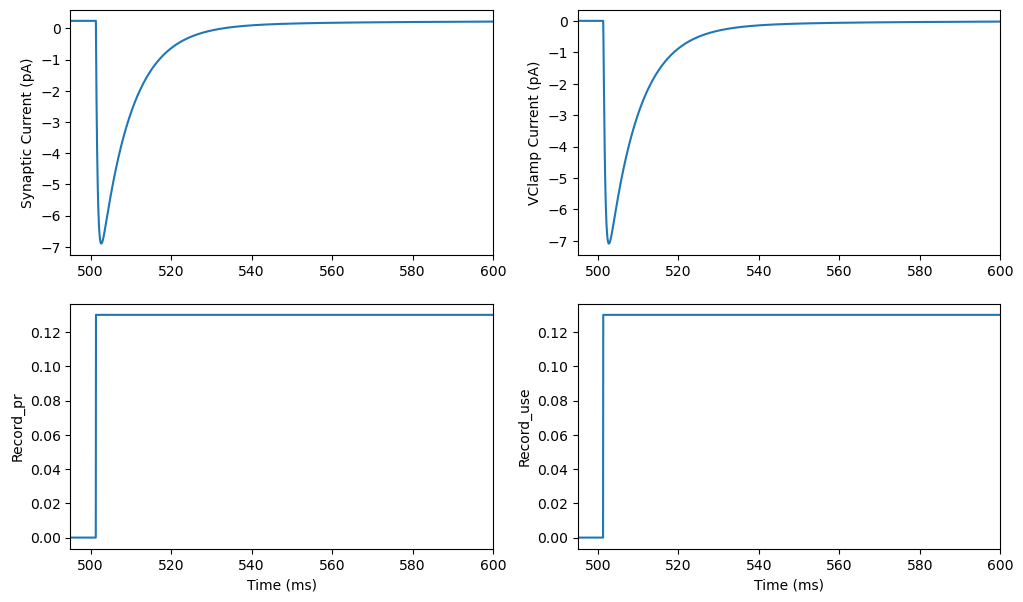

('baseline', -0.0002407732493736603)
('sign', -1.0)
('latency', 1.35)
('amp', 0.007084197529025005)
('rise_time', 0.7000000000000001)
('decay_time', 8.155594566100724)
('half_width', 8.275)


In [4]:
synapse_module.SingleEvent()

### The InteractiveTuner will deliver an input to the cell at a desired weight and frequency. The frequency by default will be 8 spikes then a 250ms delay and then 4 more spikes. 

Paired-pulse ratio is (Avg 2nd pulse - Avg 1st pulse) ÷ 90th percentile amplitude.

Induction is (Avg (6th, 7th, 8th pulses) - Avg 1st pulse) ÷ 90th percentile amplitude. 

Recovery is (Avg (9th, 10th, 11th, 12th pulses) - Avg (1st, 2nd, 3rd, 4th pulses)) ÷ 90th percentile amplitude

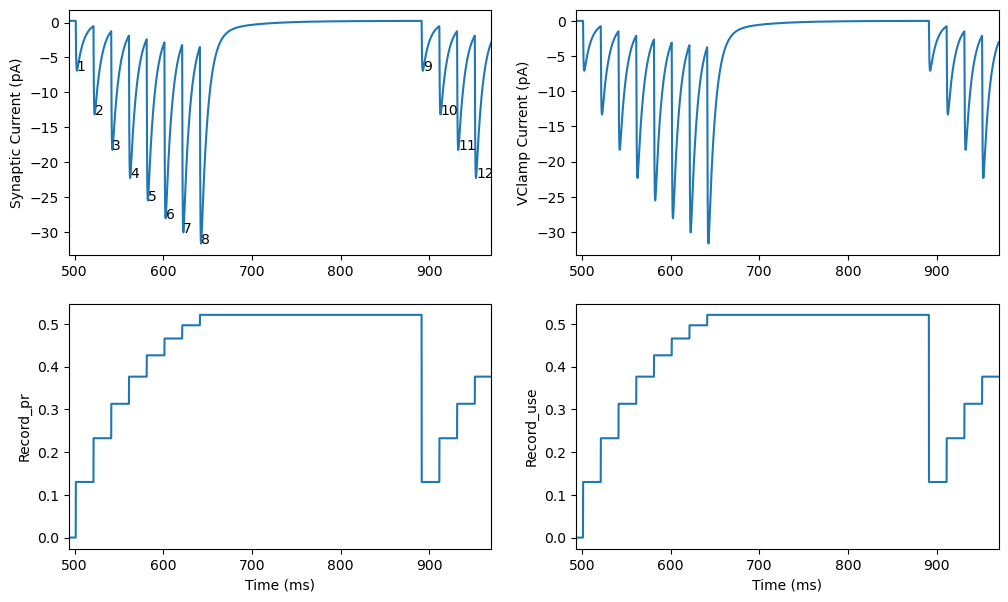


Short Term Plasticity Results
PPR: Above 1 is facilitating, below 1 is depressing.
Induction: Above 0 is facilitating, below 0 is depressing.
Recovery: A measure of how fast STP decays.

Paired Pulse Response (PPR)
Calculation: 2nd pulse / 1st pulse
Values: ([[13.16]]) / ([[6.89]]) = [[1.91]]

Induction
Calculation: (avg(6th, 7th, 8th pulses) - 1st pulse) / max amps
Values: avg([[28.  , 30.02, 31.62]]) - [[6.89]] / [31.62]
([29.88]) - ([6.89]) / [31.62] = 0.727

Recovery
Calculation: (avg(9th, 10th, 11th, 12th pulses) - avg(1st to 4th pulses)) / max amps
Values: avg([[ 6.9 , 13.16, 18.21, 22.25]]) - avg([[ 6.89, 13.16, 18.21, 22.24]]) / [31.62]
([15.13]) - ([15.13]) / [31.62] = 0.000




In [5]:
synapse_module.InteractiveTuner()

### If we don't feel like tuner by hand we can also try to optimize an output of our model. In this example we will optimize and find the best STP parameters that give the induction and paired pulse response we want. Something to note is that the optimizer does not know what the trace should look like and only knows the features. So it might get some wild trace that happens to work.

### Let's run the optimizer

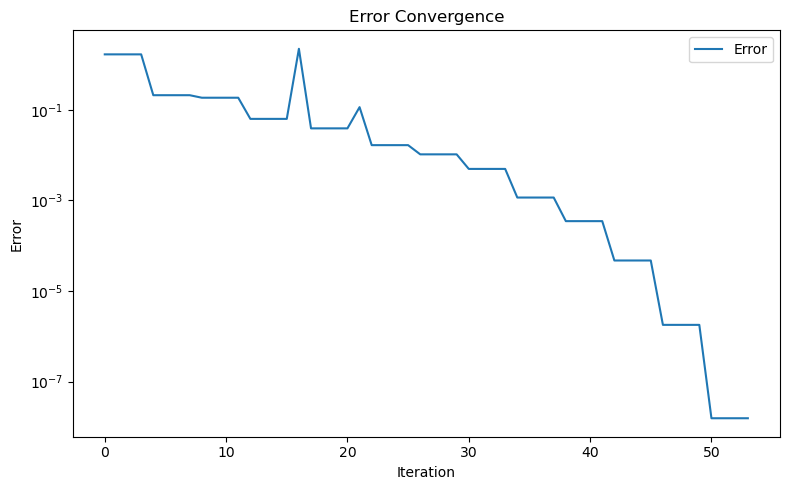

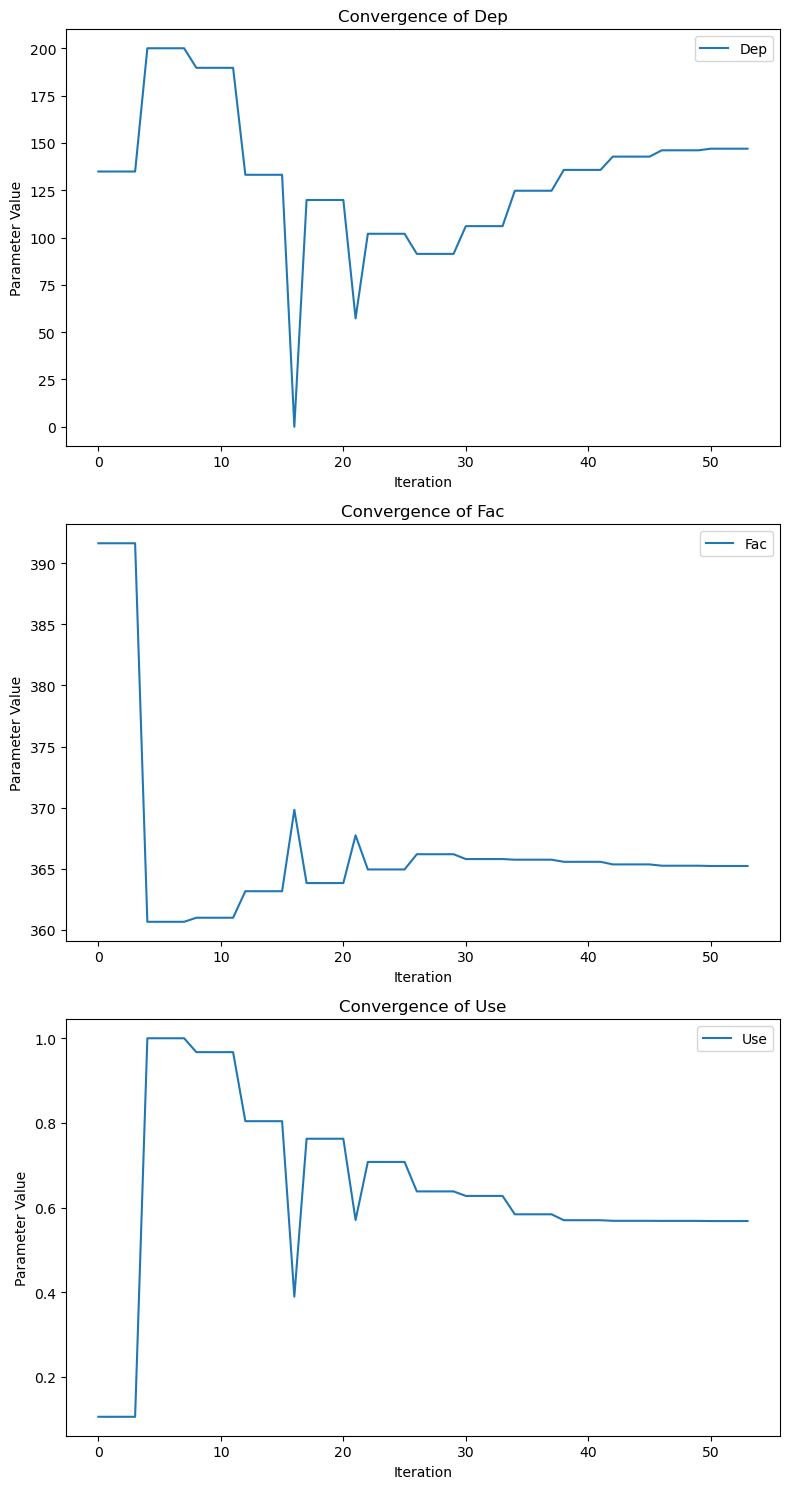

Optimization Results:
Final Error: 1.55e-08

Target Metrics:
induction: -0.750 (target: -0.750)
ppr: 0.800 (target: 0.800)

Optimal Parameters:
Dep: 146.941
Fac: 365.228
Use: 0.568


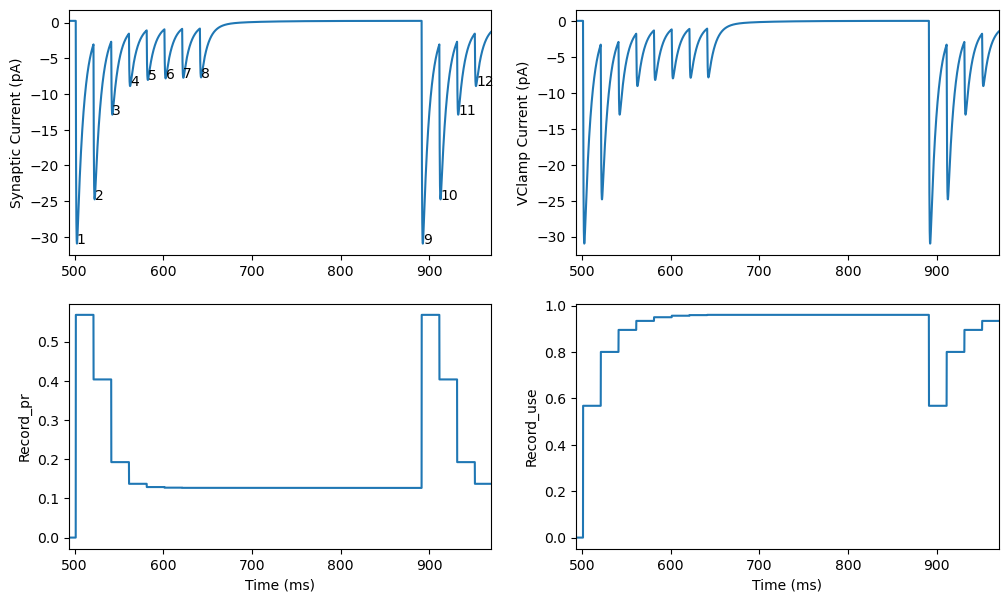


Short Term Plasticity Results
PPR: Above 1 is facilitating, below 1 is depressing.
Induction: Above 0 is facilitating, below 0 is depressing.
Recovery: A measure of how fast STP decays.

Paired Pulse Response (PPR)
Calculation: 2nd pulse / 1st pulse
Values: ([[24.74]]) / ([[30.93]]) = [[0.8]]

Induction
Calculation: (avg(6th, 7th, 8th pulses) - 1st pulse) / max amps
Values: avg([[7.81, 7.72, 7.67]]) - [[30.93]] / [30.93]
([7.73]) - ([30.93]) / [30.93] = -0.750

Recovery
Calculation: (avg(9th, 10th, 11th, 12th pulses) - avg(1st to 4th pulses)) / max amps
Values: avg([[30.93, 24.74, 12.88,  8.88]]) - avg([[30.93, 24.74, 12.88,  8.88]]) / [30.93]
([19.36]) - ([19.36]) / [30.93] = 0.000




In [6]:
from bmtool.synapses import SynapseOptimizer
# Create the optimizer
optimizer = SynapseOptimizer(synapse_module)

# Define parameter bounds
param_bounds = {
    'Dep': (0, 200.0),
    'Fac': (0, 400.0),
    'Use': (0.1, 1.0)
}

# Define target metrics
target_metrics = {
    'induction': -0.75,
    'ppr': 0.8,
    #'recovery': 0.0
}

def custom_cost(metrics, targets):
    induction_error = (metrics['induction'] - targets['induction']) ** 2
    ppr_error = (metrics['ppr'] - targets['ppr']) ** 2
    #recovery_error = (metrics['recovery'] - targets['recovery']) ** 2
    return induction_error  + 0.5 * ppr_error # lets weight them differently for fun

# Run optimization with custom cost function
result = optimizer.optimize_parameters(
    target_metrics=target_metrics,
    param_bounds=param_bounds,
    init_guess='random',
    cost_function=custom_cost,
    method='SLSQP'
)

# Plot results
optimizer.plot_optimization_results(result)